* sdg classes, num of files

In [1]:
sdg = 10
n = 38

* import

In [2]:
import nltk
from nltk import pos_tag
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import re
import json 
import pandas as pd 

* read file

In [3]:
df_train = {}
for i in range(1,n+1):
    df_train[i] = pd.read_excel(f"./dataset/SDG_Dataset_Split/SDG_Dataset_Split_{sdg}/learner-{i}.xlsx")

* transfer other sdg to 0， keep the target as 1, then shuffle the samples

In [4]:
def transfer(text, sdg):
    if text == sdg:  # 1: target
        return 1
    else:         # 0: other sdg
        return 0
import numpy as np
for i in range(1, n+1):
    df_train[i]["sdg"] = df_train[i]["sdg"].apply(lambda x: transfer(x, sdg))
    df_train[i] = df_train[i].sample(frac=1).reset_index(drop=True)

* read test file

In [5]:
test = pd.read_csv("./dataset/SDG_Dataset_Split/test.csv")
X_test = test["sample"]
test["sdg"] = test["sdg"].apply(lambda x: transfer(x, sdg))
Y_test = test["sdg"]

* Initialize results of different classifier

In [6]:
predictions = []

* LSTM binary classifier

In [7]:
def model(df_train, df_test):
    # LSTM建模
    # 设置最频繁使用的50000个词(在texts_to_matrix是会取前MAX_NB_WORDS,会取前MAX_NB_WORDS列)
    MAX_NB_WORDS = 5000
    # 每条cut_review最大的长度
    MAX_SEQUENCE_LENGTH = 100
    # 设置Embedding层的维度
    EMBEDDING_DIM = 100
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
    tokenizer.fit_on_texts(df_train['sample'].values)
    word_index = tokenizer.word_index
    print('共有 %s 个不相同的词语.' % len(word_index))
    X_train = tokenizer.texts_to_sequences(df_train['sample'].values)
    X_train = pad_sequences(X_train, maxlen=MAX_SEQUENCE_LENGTH)
    
    Y_train = pd.get_dummies(df_train['sdg']).values
    
    X_test = tokenizer.texts_to_sequences(df_test["sample"].values)
    X_test = pad_sequences(X_test, maxlen=MAX_SEQUENCE_LENGTH)
    
    Y_test = pd.get_dummies(df_test["sdg"]).values
    
    model = Sequential()
    model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_train.shape[1]))
    model.add(SpatialDropout1D(0.1))
    model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    epochs = 8
    batch_size = 64
    history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_split=0.15,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, min_delta=0.0001)])

    accr = model.evaluate(X_test, Y_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))
    print("acc:", accr[1])
    
    y_pred = model.predict(X_test)
    predictions.append(y_pred)
    y_pred = y_pred.argmax(axis=1)
    Y_test = Y_test.argmax(axis=1)

In [8]:
for i in range(1, n+1):
    model(df_train[i], test)

共有 3910 个不相同的词语.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 100, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                30200     
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
9/9 [==============================] - 4s 140ms/step - loss: 0.6919 - accuracy: 0.55

9/9 [==============================] - 1s 98ms/step - loss: 0.6661 - accuracy: 0.8263 - val_loss: 0.6568 - val_accuracy: 0.7826
Epoch 3/8
9/9 [==============================] - 1s 114ms/step - loss: 0.5678 - accuracy: 0.8301 - val_loss: 0.5318 - val_accuracy: 0.7935
Epoch 4/8
9/9 [==============================] - 1s 116ms/step - loss: 0.3509 - accuracy: 0.9170 - val_loss: 0.5289 - val_accuracy: 0.7609
Epoch 5/8
9/9 [==============================] - 1s 113ms/step - loss: 0.1887 - accuracy: 0.9305 - val_loss: 0.4091 - val_accuracy: 0.8261
Epoch 6/8
9/9 [==============================] - 1s 129ms/step - loss: 0.1282 - accuracy: 0.9749 - val_loss: 0.4290 - val_accuracy: 0.8261
Epoch 7/8
162/162 [==============================] - 2s 12ms/step - loss: 0.3455 - accuracy: 0.8578
Test set
  Loss: 0.346
  Accuracy: 0.858
acc: 0.8577777743339539
162/162 [==============================] - 2s 10ms/step
共有 3833 个不相同的词语.
Model: "sequential_4"
________________________________________________________

 embedding_7 (Embedding)     (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_7 (Spatia  (None, 100, 100)         0         
 lDropout1D)                                                     
                                                                 
 lstm_7 (LSTM)               (None, 50)                30200     
                                                                 
 dense_7 (Dense)             (None, 2)                 102       
                                                                 
Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
9/9 [==============================] - 4s 122ms/step - loss: 0.6910 - accuracy: 0.5579 - val_loss: 0.6847 - val_accuracy: 0.6196
Epoch 2/8
9/9 [==============================] - 1s 79ms/step - loss: 0.6694 - accuracy: 0.8301 - val_loss: 0.6645 - val_acc

9/9 [==============================] - 1s 99ms/step - loss: 0.5309 - accuracy: 0.7934 - val_loss: 0.4698 - val_accuracy: 0.8478
Epoch 4/8
9/9 [==============================] - 1s 91ms/step - loss: 0.2848 - accuracy: 0.9479 - val_loss: 0.4317 - val_accuracy: 0.8370
Epoch 5/8
9/9 [==============================] - 1s 92ms/step - loss: 0.1371 - accuracy: 0.9749 - val_loss: 0.5206 - val_accuracy: 0.8370
Epoch 6/8
162/162 [==============================] - 2s 10ms/step - loss: 0.3446 - accuracy: 0.9215
Test set
  Loss: 0.345
  Accuracy: 0.922
acc: 0.9215459227561951
162/162 [==============================] - 2s 10ms/step
共有 3855 个不相同的词语.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_11 (Spati  (None, 100, 100)         0         
 alDr

Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
9/9 [==============================] - 4s 118ms/step - loss: 0.6922 - accuracy: 0.5135 - val_loss: 0.6859 - val_accuracy: 0.7283
Epoch 2/8
9/9 [==============================] - 1s 82ms/step - loss: 0.6692 - accuracy: 0.8108 - val_loss: 0.6683 - val_accuracy: 0.7283
Epoch 3/8
9/9 [==============================] - 1s 83ms/step - loss: 0.5825 - accuracy: 0.8803 - val_loss: 0.5076 - val_accuracy: 0.8152
Epoch 4/8
9/9 [==============================] - 1s 85ms/step - loss: 0.3352 - accuracy: 0.9015 - val_loss: 0.5581 - val_accuracy: 0.7391
Epoch 5/8
9/9 [==============================] - 1s 85ms/step - loss: 0.2467 - accuracy: 0.9517 - val_loss: 0.3689 - val_accuracy: 0.8478
Epoch 6/8
9/9 [==============================] - 1s 79ms/step - loss: 0.1271 - accuracy: 0.9826 - val_loss: 0.3153 - val_accuracy: 0.8696
Epoch 7/8
9/9 [=============

_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_18 (Spati  (None, 100, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_18 (LSTM)              (None, 50)                30200     
                                                                 
 dense_18 (Dense)            (None, 2)                 102       
                                                                 
Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
9/9 [==============================] - 4s 155ms/step - loss: 0.6908 - accuracy: 0.5174 - val_loss: 0.6932 - val_accuracy:

Epoch 2/8
9/9 [==============================] - 1s 79ms/step - loss: 0.6735 - accuracy: 0.7645 - val_loss: 0.6877 - val_accuracy: 0.5435
Epoch 3/8
9/9 [==============================] - 1s 79ms/step - loss: 0.6144 - accuracy: 0.8012 - val_loss: 0.5992 - val_accuracy: 0.7935
Epoch 4/8
9/9 [==============================] - 1s 80ms/step - loss: 0.3967 - accuracy: 0.9073 - val_loss: 0.4518 - val_accuracy: 0.8152
Epoch 5/8
9/9 [==============================] - 1s 79ms/step - loss: 0.2036 - accuracy: 0.9672 - val_loss: 0.4166 - val_accuracy: 0.8152
Epoch 6/8
9/9 [==============================] - 1s 83ms/step - loss: 0.0922 - accuracy: 0.9865 - val_loss: 0.4925 - val_accuracy: 0.8152
Epoch 7/8
162/162 [==============================] - 1s 9ms/step - loss: 0.3491 - accuracy: 0.8609
Test set
  Loss: 0.349
  Accuracy: 0.861
acc: 0.8608695864677429
162/162 [==============================] - 2s 8ms/step
共有 3841 个不相同的词语.
Model: "sequential_22"
___________________________________________________

 embedding_25 (Embedding)    (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_25 (Spati  (None, 100, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_25 (LSTM)              (None, 50)                30200     
                                                                 
 dense_25 (Dense)            (None, 2)                 102       
                                                                 
Total params: 530,302
Trainable params: 530,302
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
9/9 [==============================] - 4s 118ms/step - loss: 0.6916 - accuracy: 0.5212 - val_loss: 0.6850 - val_accuracy: 0.6196
Epoch 2/8
9/9 [==============================] - 1s 82ms/step - loss: 0.6606 - accuracy: 0.7992 - val_loss: 0.6505 - val_acc

9/9 [==============================] - 1s 77ms/step - loss: 0.1853 - accuracy: 0.9324 - val_loss: 0.3982 - val_accuracy: 0.7935
Epoch 6/8
9/9 [==============================] - 1s 81ms/step - loss: 0.1056 - accuracy: 0.9807 - val_loss: 0.3890 - val_accuracy: 0.8043
Epoch 7/8
9/9 [==============================] - 1s 83ms/step - loss: 0.0616 - accuracy: 0.9942 - val_loss: 0.3517 - val_accuracy: 0.8261
Epoch 8/8
162/162 [==============================] - 1s 9ms/step - loss: 0.4592 - accuracy: 0.8133
Test set
  Loss: 0.459
  Accuracy: 0.813
acc: 0.8133333325386047
162/162 [==============================] - 2s 8ms/step
共有 3819 个不相同的词语.
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_29 (Spati  (None, 100, 100)         0         
 alDrop

Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/8
9/9 [==============================] - 3s 119ms/step - loss: 0.6905 - accuracy: 0.5734 - val_loss: 0.6829 - val_accuracy: 0.7500
Epoch 2/8
9/9 [==============================] - 1s 78ms/step - loss: 0.6576 - accuracy: 0.8764 - val_loss: 0.6244 - val_accuracy: 0.8804
Epoch 3/8
9/9 [==============================] - 1s 78ms/step - loss: 0.5159 - accuracy: 0.8224 - val_loss: 0.5363 - val_accuracy: 0.6522
Epoch 4/8
9/9 [==============================] - 1s 78ms/step - loss: 0.4055 - accuracy: 0.9324 - val_loss: 0.4263 - val_accuracy: 0.9022
Epoch 5/8
9/9 [==============================] - 1s 82ms/step - loss: 0.2542 - accuracy: 0.9421 - val_loss: 0.3334 - val_accuracy: 0.8696
Epoch 6/8
9/9 [==============================] - 1s 83ms/step - loss: 0.1360 - accuracy: 0.9672 - val_loss: 0.3028 - val_accuracy: 0.9457
Epoch 7/8
9/9 [==============================] - 1s 93ms/step - loss: 0.0880

162/162 [==============================] - 1s 9ms/step - loss: 0.3120 - accuracy: 0.8993
Test set
  Loss: 0.312
  Accuracy: 0.899
acc: 0.8993236422538757
162/162 [==============================] - 2s 9ms/step
共有 3850 个不相同的词语.
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 100, 100)          500000    
                                                                 
 spatial_dropout1d_36 (Spati  (None, 100, 100)         0         
 alDropout1D)                                                    
                                                                 
 lstm_36 (LSTM)              (None, 50)                30200     
                                                                 
 dense_36 (Dense)            (None, 2)                 102       
                                                                 
Total params: 530,302
Tra

* Integrate & vote

In [9]:
for i in range(n):
    for j in range(len(predictions[0])):
        if predictions[i][j][0] >= predictions[i][j][1]:
            predictions[i][j][0] = 1
            predictions[i][j][1] = 0
        else:
            predictions[i][j][0] = 0
            predictions[i][j][1] = 1 
prediction = predictions[0]
Y_test = pd.get_dummies(test["sdg"]).values
for j in range(len(predictions[0])):
    sum1 = 0
    sum2 = 0
    for i in range(n):
        sum1 += predictions[i][j][0]
        sum2 += predictions[i][j][1]
        if sum1 >= sum2:
            prediction[j][0] = 1
            prediction[j][1] = 0
        else:
            prediction[j][0] = 0
            prediction[j][1] = 1 

* performence of final classifier

In [10]:
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print('accuracy %s' % accuracy_score(prediction, Y_test))
print(classification_report(Y_test, prediction, zero_division=0))

accuracy 0.8960386473429952
              precision    recall  f1-score   support

           0       1.00      0.90      0.94      5046
           1       0.18      0.87      0.29       129

   micro avg       0.90      0.90      0.90      5175
   macro avg       0.59      0.88      0.62      5175
weighted avg       0.98      0.90      0.93      5175
 samples avg       0.90      0.90      0.90      5175



* confusion matrix

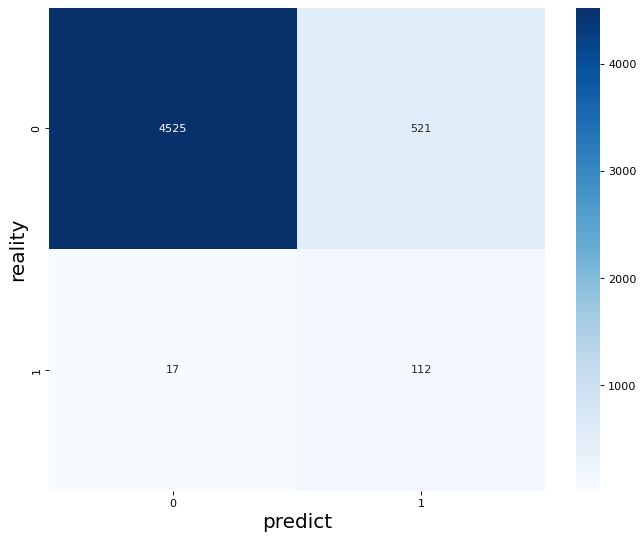

In [11]:
# one-hot -> number
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
Y_test_list = []
for i in range(len(Y_test)):
    if Y_test[i][0] == 1:
        Y_test_list.append(0)
    else:
        Y_test_list.append(1)
Y_pre_list = []
for i in range(len(prediction)):
    if prediction[i][0] == 1:
        Y_pre_list.append(0)
    else:
        Y_pre_list.append(1)
# confusion matrix
conf_mat = confusion_matrix(Y_test_list, Y_pre_list)
fig, ax = plt.subplots(figsize=(10,8), dpi=80)
sns.heatmap(conf_mat, annot=True, fmt='d',xticklabels=range(0,2), yticklabels=range(0,2), cmap="Blues")
plt.ylabel('reality',fontsize=18)
plt.xlabel('predict',fontsize=18)
plt.show()
